In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

In [2]:
from etherscan.accounts import Account

In [3]:
import brownie

brownie.network.connect("mainnet")

In [4]:
import requests as requests

In [5]:
block_info_response = requests.get("https://api.blockcypher.com/v1/eth/main")
current_block = block_info_response.json()['height']

In [6]:
crv_depositor_contract = "0x8014595F2AB54cD7c604B00E9fb932176fDc86Ae"
crv_depositor_contract_obj = brownie.network.contract.Contract.from_explorer(crv_depositor_contract)

Fetching source of 0x8014595F2AB54cD7c604B00E9fb932176fDc86Ae from api.etherscan.io...


/Users/swadhinnanda/Projects/git/on-chain-analytics/venv/lib/python3.7/site-packages/brownie/network/contract.py:1239: BrownieCompilerWarning: 0x8014595F2AB54cD7c604B00E9fb932176fDc86Ae: Locally compiled and on-chain bytecode do not match!
  BrownieCompilerWarning,


In [36]:
go_back = 100000
query = f"https://api.etherscan.io/api?module=account&action=txlist&address={crv_depositor_contract}&startblock={current_block-go_back}&endblock={current_block}&sort=asc&page=1&offset=10000&apikey={os.environ['ETHERSCAN_API_KEY']}"
etherscan_api_response = requests.post(query)
etherscan_api_response

<Response [200]>

In [8]:
crv_depositor_txes = etherscan_api_response.json()['result']
len(crv_depositor_txes)

489

In [9]:
example_tx = crv_depositor_txes[10]
tx_receipt = brownie.network.transaction.TransactionReceipt(example_tx['hash'])
tx_receipt.info()

Transaction was Mined 
---------------------
Tx Hash: 0x5a0ff1171473dc024593535eca85c92a2daf818521ab4f5ca0f7cd478b3d49c5
From: 0x58eB8Ac35D7fa28483A104932B9665e326b937E0
To: 0x8014595F2AB54cD7c604B00E9fb932176fDc86Ae
Value: 0
Function: CrvDepositor.deposit
Block: 13069317
Gas Used: 216322 / 394716 (54.8%)

Events In This Transaction
--------------------------
├── 0xD533a949740bb3306d119CC777fa900bA034cd52
│   └── Transfer
│       ├── _from: 0x58eB8Ac35D7fa28483A104932B9665e326b937E0
│       ├── _to: 0x8014595F2AB54cD7c604B00E9fb932176fDc86Ae
│       └── _value: 591176555810000000000
│   
├── 0x62B9c7356A2Dc64a1969e19C23e4f579F9810Aa7
│   ├── Transfer
│   │   ├── _from: 0x0000000000000000000000000000000000000000
│   │   ├── _to: 0x8014595F2AB54cD7c604B00E9fb932176fDc86Ae
│   │   └── _value: 591176555810000000000
│   ├── Approval
│   │   ├── _owner: 0x8014595F2AB54cD7c604B00E9fb932176fDc86Ae
│   │   ├── _spender: 0x3Fe65692bfCD0e6CF84cB1E7d24108E434A7587e
│   │   └── _value: 0
│   └── Ap

In [10]:
crv_lock_txes = {'timestamp': [], 'qt': [], 'gas_price': []}
for tx in crv_depositor_txes:
    try:
        tx_receipt = brownie.network.transaction.TransactionReceipt(tx['hash'])
        if tx_receipt.fn_name == 'deposit':
            crv_lock_txes['qt'].append(tx_receipt.events[0]['_value'] * 1e-18)
            crv_lock_txes['gas_price'].append(tx_receipt.gas_price * 1e-9)
            crv_lock_txes['timestamp'].append(datetime.datetime.fromtimestamp(tx_receipt.timestamp))
    except:
        continue

In [13]:
df_crv_lock_txes = pd.DataFrame(crv_lock_txes)
df_crv_lock_txes.set_index('timestamp', inplace=True)
df_crv_lock_txes

,qt,gas_price
timestamp,,
2021-08-21 14:06:21,2789.659017,25.000000
2021-08-21 14:10:47,2745.190486,23.000000
2021-08-21 14:26:08,65945.764863,20.000000
2021-08-21 14:45:11,5524.147376,30.000000
2021-08-21 14:50:03,235.408537,21.000000
...,...,...
2021-09-05 22:05:08,30544.124523,106.000000
2021-09-05 22:32:44,251677.750000,89.000000
2021-09-05 22:39:40,30110.679094,88.537931


In [33]:
df_crv_lock_daily = pd.DataFrame()
df_crv_lock_daily['avg_gas'] = df_crv_lock_txes.groupby(pd.Grouper(freq='1D'))['gas_price'].mean()
df_crv_lock_daily['total_locked'] = df_crv_lock_txes.groupby(pd.Grouper(freq='1D'))['qt'].sum() / 10000
df_crv_lock_daily

,avg_gas,total_locked
timestamp,,
2021-08-21,35.772382,28.598153
2021-08-22,28.696988,28.162809
2021-08-23,41.804545,30.036073
2021-08-24,68.823067,84.195634
2021-08-25,74.833333,69.152679
2021-08-26,79.330284,14.749192
2021-08-27,69.974074,59.423923
2021-08-28,60.954227,94.287892
2021-08-29,60.325949,28.593548


Text(0.5, 1.0, 'total locked crv (x10000) and average gas each day')

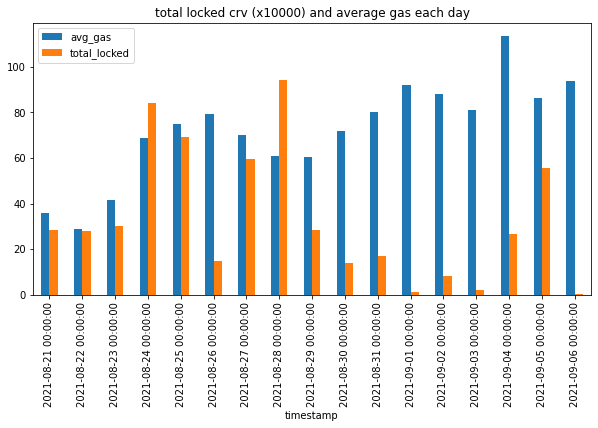

In [35]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
df_crv_lock_daily.plot(ax=ax, kind='bar')
ax.set_title("total locked crv (x10000) and average gas each day")